# Efficacy of a new hospital procedure: A DID analysis

The following notebook will use difference-in-differences (DID) regression to estimate the effect of a new admissions procedure on the hospitals that participated in the program.

To answer this question, we will use monthly data on patients from January to July. The new
admissions procedure was implemented in April by hospitals that were under new management. Of
the 46 hospitals in the study, 18 implemented the new procedure.

In [1]:
# First, import modules and configure Stata
from pandas import json_normalize
import json

import stata_setup
stata_setup.config("/Applications/Stata17", "mp")
from pystata import stata


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user 4-core network perpetual
Serial number: 17
  Licensed to: Meghan Cain
               StataCorp

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


In [2]:
# Import json data
with open("../Documents/did.json") as json_file:
    data = json.load(json_file)
data = json_normalize(data, 'records', ['hospital_id', 'month'])
data.head(10)

,procedure,satisfaction_score,hospital_id,month
0,New,4.1065269,1,7
1,Old,3.3194752,1,3
2,Old,3.4117203,1,2
3,New,3.0040255,1,4
4,Old,3.1107202,1,3
5,New,2.8821645,1,7
6,New,4.4102569,1,4
7,Old,2.9028852,1,1
8,Old,3.0502264,1,3
9,Old,2.4388423,1,1


In [3]:
# Perform analysis using API functions

# First, pass data into Stata and clean it
stata.pdataframe_to_data(data, True)

stata.run('''
destring satisfaction_score, replace
destring hospital_id, replace
destring month, replace
gen proc = 0
replace proc = 1 if procedure == "New"
label define procedure 0 "Old" 1 "New"
drop procedure
rename proc procedure
label value procedure procedure
''', quietly=True)

We would like to fit the following model to our data: 

$ satisfaction = \hat{\gamma}_{s} + \hat{\gamma}_{t} + \hat{\delta}procedure_{st} + {\varepsilon}_{ist} $ 

where $\hat{\gamma}_{s}$ are the hospital fixed effects, $\hat{\gamma}_{t}$ are the month fixed effects, and ${\varepsilon}_{ist}$ is the error term.

In [4]:
stata.run("didregress (satisfaction_score) (procedure), group(hospital_id) time(month)")


Number of groups and treatment time

Time variable: month
Control:       procedure = 0
Treatment:     procedure = 1
-----------------------------------
             |   Control  Treatment
-------------+---------------------
Group        |
 hospital_id |        28         18
-------------+---------------------
Time         |
     Minimum |         1          4
     Maximum |         1          4
-----------------------------------

Difference-in-differences regression                     Number of obs = 7,368
Data type: Repeated cross-sectional

                           (Std. err. adjusted for 46 clusters in hospital_id)
------------------------------------------------------------------------------
             |               Robust
satisfacti~e | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
ATET         |
   procedure |
       (New  |
         vs  |
       Old)  |   .8479879   .0321121

In [5]:
# Load Stata results to Python
r = stata.get_return()['r(table)']
e = stata.get_ereturn()['e(group_count)']

# Use Stata results in Python
print("Of the %2.0f hospitals in this provider network, %2.0f implemented the new admissions procedure. These hospitals had an \n%4.2f-point increase in patient satisfaction relative to the case where they do not implement the new policy (95%% CI [%4.2f, %4.2f])." 
      % (e[2][0], e[1][0], r[0][0], r[4][0], r[5][0]))

Of the 46 hospitals in this provider network, 18 implemented the new admissions procedure. These hospitals had an 
0.85-point increase in patient satisfaction (95% CI [0.78, 0.91]).



. 
. estat trendplots

. graph export ptrend.png, replace
file ptrend.png written in PNG format

. estat ptrend

Parallel-trends test (pretreatment time period)
H0: Linear trends are parallel

F(1, 45) =   0.55
Prob > F = 0.4615

. estat granger

Granger causality test
H0: No effect in anticipation of treatment

F(2, 45) =   0.33
Prob > F = 0.7239

. 


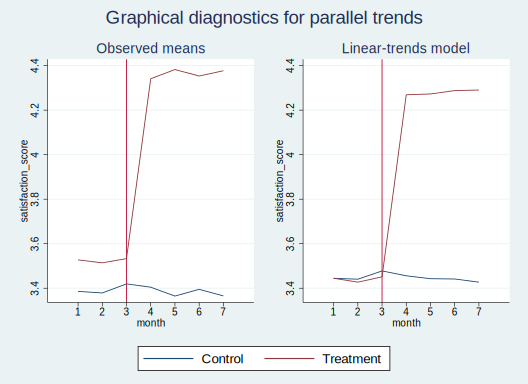

In [6]:
# Conduct diagnostics
stata.run('''
estat trendplots
graph export ptrend.png, replace
estat ptrend
estat granger''')

We cannot reject the null hypothesis of parallel linear trends. Likewise,
we do not reject the null hypothesis of the absence of anticipatory effects

In [4]:
# Perform analysis using Stata magic
# First, clear Stata
%stata clear

In [5]:
%%stata -d data -ret myret -eret myeret
destring satisfaction_score, replace
destring hospital_id, replace
destring month, replace
gen proc = 0
replace proc = 1 if procedure == "New"
label define procedure 0 "Old" 1 "New"
drop procedure
rename proc procedure
label value procedure procedure
didregress (satisfaction_score) (procedure), group(hospital_id) time(month)


. destring satisfaction_score, replace
satisfaction_score: all characters numeric; replaced as double

. destring hospital_id, replace
hospital_id: all characters numeric; replaced as byte

. destring month, replace
month: all characters numeric; replaced as byte

. gen proc = 0

. replace proc = 1 if procedure == "New"
(1,532 real changes made)

. label define procedure 0 "Old" 1 "New"

. drop procedure

. rename proc procedure

. label value procedure procedure

. didregress (satisfaction_score) (procedure), group(hospital_id) time(month)

Number of groups and treatment time

Time variable: month
Control:       procedure = 0
Treatment:     procedure = 1
-----------------------------------
             |   Control  Treatment
-------------+---------------------
Group        |
 hospital_id |        28         18
-------------+---------------------
Time         |
     Minimum |         1          4
     Maximum |         1          4
-----------------------------------

Difference-in-di

In [6]:
print("Of the %2.0f hospitals in this provider's network, %2.0f implemented the new admissions procedure. These hospitals had an \n%4.2f-point increase in patient satisfaction relative to the case where they do not implement the new policy (95%% CI [%4.2f, %4.2f])." 
      % (myeret['e(group_count)'][2][0], myeret['e(group_count)'][1][0], myret['r(table)'][0][0],myret['r(table)'][0][0], myret['r(table)'][0][0]))

Of the 46 hospitals in this provider's network, 18 implemented the new admissions procedure. These hospitals had an 
0.85-point increase in patient satisfaction (95% CI [0.85, 0.85]).


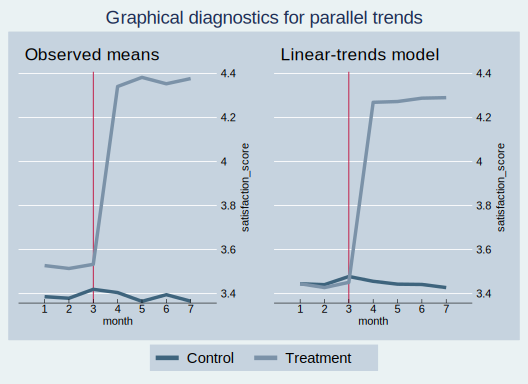

In [7]:
%stata estat trendplots, scheme(economist)

In [10]:
%%stata -ret myret
estat ptrend


Parallel-trends test (pretreatment time period)
H0: Linear trends are parallel

F(1, 45) =   0.55
Prob > F = 0.4615


In [11]:
print("We cannot reject the null hypothesis of parallel linear trends, F(%1.0f,%2.0f) = %2.2f, p=%1.3f])." 
      % (myret['r(df)'],myret['r(df_r)'],myret['r(F)'],myret['r(p)']))


We cannot reject the null hypothesis of parallel linear trends, F(1,45) = 0.55, p=0.462]).


In this example, we had a sufficient number of hospitals (46) to make reliable inferences about our treatment effect. If we only had data from 15 hospitals, however, we may have considered alternative methods.

In [10]:
%%stata
collect clear
* collect estimates and confidence intervals from each model
quietly collect _r_b _r_ci: didregress (satis) (procedure), group(hospital) time(month)
quietly collect _r_b _r_ci: ///
didregress (satis) (procedure), group(hospital) time(month) vce(hc2)
quietly collect _r_b _r_ci: ///
didregress (satis) (procedure), group(hospital) time(month) aggregate(dlang)
quietly collect _r_b _r_ci: ///
didregress (satis) (procedure), group(hospital) time(month) wildbootstrap(rseed(111))

/* put each model (cmdset) in the rows and each ATET parameter 
(colname[r1vs0.procedure]) with its estimate (result) in the columns */ 
collect layout (cmdset) (colname[r1vs0.procedure]#result)

* label each model
collect label levels cmdset 1 "Cluster-robust" 2 "Bell & McCaffrey" ///
3 "Donald & Lang" 4 "Wild-cluster bootstrap", modify

* change label for _r_b
collect label levels result _r_b "ATET", modify

* hide the label for the level of colname
collect style header colname, level(hide)

* use a comma for CIs and enclose in []
collect style cell result[_r_ci], cidelimiter(", ") sformat("[%s]")
  
* changed numeric format for all results to include leading zeros
collect style cell result, nformat(%05.3f)

* removed border
collect style cell border_block[corner row-header], border(right, pattern(nil))

collect preview
collect export did.pdf, replace


. collect clear

. * collect estimates and confidence intervals from each model
. quietly collect _r_b _r_ci: didregress (satis) (procedure), group(hospital) t
> ime(month)

. quietly collect _r_b _r_ci: ///
> didregress (satis) (procedure), group(hospital) time(month) vce(hc2)

. quietly collect _r_b _r_ci: ///
> didregress (satis) (procedure), group(hospital) time(month) aggregate(dlang)

. quietly collect _r_b _r_ci: ///
> didregress (satis) (procedure), group(hospital) time(month) wildbootstrap(rse
> ed(111))

. 
. /* put each model (cmdset) in the rows and each ATET parameter 
> (colname[r1vs0.procedure]) with its estimate (result) in the columns */ 
. collect layout (cmdset) (colname[r1vs0.procedure]#result)

Collection: default
      Rows: cmdset
   Columns: colname[r1vs0.procedure]#result
   Table 1: 4 x 2

----------------------------------
  |   procedure      procedure    
  |  (New vs 0)     (New vs 0)    
  | Coefficient       95% CI      
--+-----------------------------